# Measuring Customer Lifetime Value (LTV) in Python

While consuimg the notebbok, We can learn how to measure the customer LTV (Lifetime Value) for any custom timeframe we want. We form an example using a real-world marketing dataset provided by Kaggle

### WHAT IS CUSTOMER LIFETIME VALUE?

**Customer lifetime value is how much money a customer will bring your brand throughout their entire time as a paying customer.**

At a glance, CLTV tells you how much a customer is worth to your brand and gives you insight into their overall value. From there, you’ll have a better understanding of how much you should be investing in customer retention going forward.

Not only that, but customer lifetime value clues you into whether or not you can expect certain customers to become repeat customers. If their customer lifetime value is high, chances are they’re fans of your brand and will continue to buy more of your products. If not, they’re likely just a passive customer who made a one-time purchase and will take extra effort to re-engage.

Customer lifetime value is one of the most important metrics to keep in mind in businses marketing. This metric is especially important to keep track of for acquiring new customers. The corporate goal of marketing kampagnien is always the acquisition of new customers under the premise of a positive ROI. 

For example, if the average CLV of our customer is 100 dollar and it only costs 50 dollar to acquire a new customer, then our business will be generationg more revenue as we acquire new customers. If this is the other way around, our company is making losses. This is to be avoided and for this reason the CLV should always be observed.

[Reference](https://www.zaius.com/customer-lifetime-value-cltv/)

There are multiple ways to calculate CLV. In its simplest form, you can calculate CLTV by taking your average order value, multiplying by your average customer’s purchase frequency, then dividing that number by your average customer lifespan. 

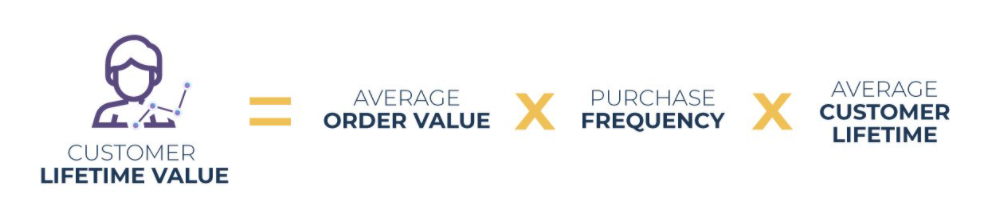

In example scenario for a customer below:

- Customer’s average purchase amount: 100 dollar
- Purchase frequency: 5 times per month

This makes an average value per month of 500€. Now let’s come to the lifetime span. 

One way to estimate a customer’s lifetime span is to look at the average monthly churn rate, which is the percentage of customers leaving and terminating the relationship whith our business. We can estimate a customer’s lifetime span by dividing one by the churn rate. Assuming 5% of the churn rate, the estimated customer’s lifetime span is 20 years.

- Lifetime span: 20 years

This results in a total CLV amount of **120,000 dollar** (500 dollar x 20 years x 12 months).

Because we do not typically know the lifetime span of customers, we often try to estimate CLV over the course of a certain period (3 months, 12 months, 24 months …)

# 1.0 Import Libraries and Load Data

We will be using the Real-world transactions dataset. 

It contains about 500,000 transaction records occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail

Dataset can be downloaded [Here](https://www.kaggle.com/carrie1/ecommerce-data/)

In [14]:
import gc
import os
import time
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from collections import defaultdict

In [15]:
pwd

'/home/bhj623/code/Python-Projects/GeneralML/Cohort_Basket_Analysis'

In [17]:
df = pd.read_csv("/home/bhj623/code/Python-Projects/GeneralML/data/retail.csv", encoding = "ISO-8859-1")

# -- Convert InvoiceDate from object to datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [18]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# 3.0 Preprocess the dataset 

In [22]:
'''
Canceled orders could cause negative values in the data record.
To be on the safe side, these are removed.
'''

df = df.loc[df['Quantity'] > 0]
df.shape

(531285, 8)

In [23]:
'''
We need to drop observations with no CustomerID
'''

df = df[pd.notnull(df['CustomerID'])]
df.shape

(397924, 8)

In [24]:
'''
Due to the fact that we only need full months for future analysis, we will shorten this data set accordingly.
'''
print('Invoice Date Range: %s - %s' % (df['InvoiceDate'].min(), df['InvoiceDate'].max()))

df = df.loc[df['InvoiceDate'] < '2011-12-01']
df.shape

Invoice Date Range: 2010-12-01 08:26:00 - 2011-12-09 12:50:00


(380620, 8)

In [25]:
'''
For further analysis we need another column Sales.
'''
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [26]:
'''
Here we group the dataframe by CustimerID and InvoiceNo and 
aggregate the Sales column as well as the InvoiceDate, to create a fianl dataset
'''

orders_df = df.groupby(['CustomerID', 'InvoiceNo']).agg({
    'Sales': sum,
    'InvoiceDate': max
})

orders_df.head()

Sales         InvoiceDate
CustomerID InvoiceNo                              
12346.0    541431     77183.60 2011-01-18 10:01:00
12347.0    537626       711.79 2010-12-07 14:57:00
           542237       475.39 2011-01-26 14:30:00
           549222       636.25 2011-04-07 10:43:00
           556201       382.52 2011-06-09 13:01:00

In [27]:
'''
For the preparation of the data for descriptive part we need the following functions:
'''


def groupby_mean(x):
    return x.mean()

def groupby_count(x):
    return x.count()

def purchase_duration(x):
    return (x.max() - x.min()).days

def avg_frequency(x):
    return (x.max() - x.min()).days/x.count()

groupby_mean.__name__ = 'avg'
groupby_count.__name__ = 'count'
purchase_duration.__name__ = 'purchase_duration'
avg_frequency.__name__ = 'purchase_frequency'

In [28]:
'''
Re-group the record by CustomerID and aggregate the Sales and InvoiceDate columns with the previously created functions
'''

summary_df = orders_df.reset_index().groupby('CustomerID').agg({
    'Sales': [min, max, sum, groupby_mean, groupby_count],
    'InvoiceDate': [min, max, purchase_duration, avg_frequency]
})

summary_df.head()

Sales                                          \
                 min       max       sum           avg count   
CustomerID                                                     
12346.0     77183.60  77183.60  77183.60  77183.600000   1.0   
12347.0       382.52   1294.32   4085.18    680.863333   6.0   
12348.0       227.44    892.80   1797.24    449.310000   4.0   
12349.0      1757.55   1757.55   1757.55   1757.550000   1.0   
12350.0       334.40    334.40    334.40    334.400000   1.0   

                   InvoiceDate                                        \
                           min                 max purchase_duration   
CustomerID                                                             
12346.0    2011-01-18 10:01:00 2011-01-18 10:01:00                 0   
12347.0    2010-12-07 14:57:00 2011-10-31 12:25:00               327   
12348.0    2010-12-16 19:09:00 2011-09-25 13:13:00               282   
12349.0    2011-11-21 09:51:00 2011-11-21 09:51:00                 0   
12350.0    2011-02-02 16:01:00 2011-02-02 16:01:00                 0   

                               
           purchase_frequency  
CustomerID                     
12346.0                   0.0  
12347.0                  54.5  
12348.0                  70.5  
12349.0                   0.0  
12350.0                   0.0

In [29]:
'''
Clean a little bit
'''
summary_df.columns = ['_'.join(col).lower() for col in summary_df.columns]
summary_df = summary_df.reset_index()
summary_df.head()

,CustomerID,sales_min,sales_max,sales_sum,sales_avg,sales_count,invoicedate_min,invoicedate_max,invoicedate_purchase_duration,invoicedate_purchase_frequency
0,12346.0,77183.60,77183.60,77183.60,77183.600000,1.0,2011-01-18 10:01:00,2011-01-18 10:01:00,0,0.0
1,12347.0,382.52,1294.32,4085.18,680.863333,6.0,2010-12-07 14:57:00,2011-10-31 12:25:00,327,54.5
2,12348.0,227.44,892.80,1797.24,449.310000,4.0,2010-12-16 19:09:00,2011-09-25 13:13:00,282,70.5
3,12349.0,1757.55,1757.55,1757.55,1757.550000,1.0,2011-11-21 09:51:00,2011-11-21 09:51:00,0,0.0
4,12350.0,334.40,334.40,334.40,334.400000,1.0,2011-02-02 16:01:00,2011-02-02 16:01:00,0,0.0


## **Exaplanation**

This dataset gives us an idea of the purchases each customer has made. 

Let’s have a look at **CustomerID 12346 (first row)**. This customer made only one purchase on January 18,2011.

**The second customer (12347)** has made six purchases within December 7, 2010 and October 31, 2011. The timespan here is about 327 days. The average amount this customer spent on each order is 680. We also see from the record, that this customer made a purchase every 54.5 days.

# 4.0 Visualization

### For the visualization part we are only interested in the purchases that the repeat customers have made.

In [30]:
summary_df = summary_df.loc[summary_df['invoicedate_purchase_duration'] > 0]
summary_df.shape

(2692, 10)

As we can see, there are only 2692 (of 4298) repeat customers in the record.

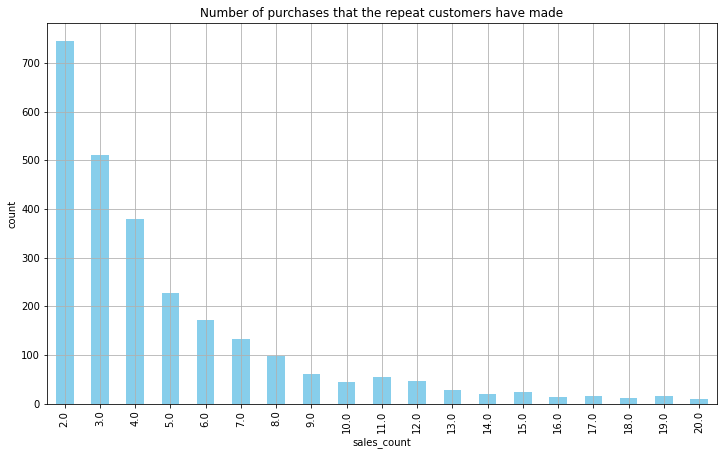

In [31]:
'''
This plot shows the distributions of the number of purchases that the repeat customers have made
'''

ax = summary_df.groupby('sales_count').count()['sales_avg'][:20].plot(
    kind='bar', 
    color='skyblue',
    figsize=(12,7), 
    grid=True
)

ax.set_ylabel('count')
plt.title('Number of purchases that the repeat customers have made')

plt.show()

### As we can see from this plot, the majority of customers have made 10 or less purchases. Here a few more metrics about sales_count:

### Now we are going to have a look at the average number of days between purchases for these repeat customers.

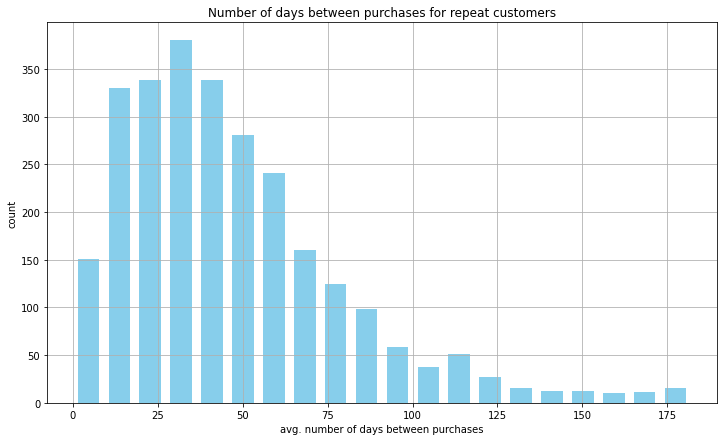

In [32]:
'''
This plot shows the average number of days between purchases for repeat customers.
It is an overall view of how frequently repeat customers made purchases historically.
'''

ax = summary_df['invoicedate_purchase_frequency'].hist(
    bins=20,
    color='skyblue',
    rwidth=0.7,
    figsize=(12,7)
)

ax.set_xlabel('avg. number of days between purchases')
ax.set_ylabel('count')
plt.title('Number of days between purchases for repeat customers')

plt.show()

### As we can see from this plot, the majority of repeat customers made purchases every 20-50 days.

# 5.0 Predicting 3-Month CLV

Use the final created dataset **orders_df** at this point (chapter Data pre-processing / Create final dataframe)

In [33]:
# Determine the frequency
clv_freq = '3M'

# Group by CustomerID 
# Break down the data into chunks of 3 months for each customer
# Aggregate the sales column by sum
# Aggregate the sales column by average_sum and count (both with the previous created functions)
data_df = orders_df.reset_index().groupby([
    'CustomerID',
    pd.Grouper(key='InvoiceDate', freq=clv_freq)
]).agg({
    'Sales': [sum, groupby_mean, groupby_count],
})

# Bring the dataset in a readable format
data_df.columns = ['_'.join(col).lower() for col in data_df.columns]
data_df = data_df.reset_index()
data_df.head()

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count
0,12346.0,2011-03-31,77183.60,77183.600,1.0
1,12347.0,2010-12-31,711.79,711.790,1.0
2,12347.0,2011-03-31,475.39,475.390,1.0
3,12347.0,2011-06-30,1018.77,509.385,2.0
4,12347.0,2011-09-30,584.91,584.910,1.0


### Now we are going to **encode the InvoiceDate column** values so that they are easier to read than the current date format.

In [34]:
# Set the length of the column InvoiceDate. In our case = 10
length_of_InvoiceDate = 10

date_month_map = {
    str(x)[:length_of_InvoiceDate]: 'M_%s' % (i+1) for i, x in enumerate(
        sorted(data_df.reset_index()['InvoiceDate'].unique(), reverse=True)
    )
}
date_month_map

{'2011-12-31': 'M_1',
 '2011-09-30': 'M_2',
 '2011-06-30': 'M_3',
 '2011-03-31': 'M_4',
 '2010-12-31': 'M_5'}

As you can see, we encoded the date values into M_1, M_2 and so on.

In [35]:
'''
Apply the generated dictionary to the dataframe for prediction models
'''

data_df['M'] = data_df['InvoiceDate'].apply(lambda x: date_month_map[str(x)[:length_of_InvoiceDate]])
data_df.head(10)

,CustomerID,InvoiceDate,sales_sum,sales_avg,sales_count,M
0,12346.0,2011-03-31,77183.60,77183.600,1.0,M_4
1,12347.0,2010-12-31,711.79,711.790,1.0,M_5
2,12347.0,2011-03-31,475.39,475.390,1.0,M_4
3,12347.0,2011-06-30,1018.77,509.385,2.0,M_3
4,12347.0,2011-09-30,584.91,584.910,1.0,M_2
5,12347.0,2011-12-31,1294.32,1294.320,1.0,M_1
6,12348.0,2010-12-31,892.80,892.800,1.0,M_5
7,12348.0,2011-03-31,227.44,227.440,1.0,M_4
8,12348.0,2011-06-30,367.00,367.000,1.0,M_3
9,12348.0,2011-09-30,310.00,310.000,1.0,M_2


### 5.2 Building Sample Set

Now we are ready to create a sample set with features and target variables. In this case, we are going to use the **last 3 months** as the target variable and the rest as the features. 

In other words, **we are going to train a machie learning model that predicts the last 3 months’customer value** with the rest of the data.

In [36]:
# Exclude M_1 because this will be our predictor variable.
features_df = pd.pivot_table(
    data_df.loc[data_df['M'] != 'M_1'], 
    values=['sales_sum', 'sales_avg', 'sales_count'], 
    columns='M', 
    index='CustomerID'
)

# Prepare the features dataframe for better view
features_df.columns = ['_'.join(col) for col in features_df.columns]

# Encode NaN values with 0.0
features_df = features_df.fillna(0)
features_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5
CustomerID,,,,,,,,,,,,
12346.0,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00
12347.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79
12348.0,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80
12350.0,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00
12352.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00
18281.0,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00
18282.0,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00


In [37]:
# Just select M_1 because this is our target variable
response_df = data_df.loc[
    data_df['M'] == 'M_1',
    ['CustomerID', 'sales_sum']
]

# Rename the columns accordingly
response_df.columns = ['CustomerID', 'CLV_'+clv_freq]
response_df

,CustomerID,CLV_3M
5,12347.0,1294.32
10,12349.0,1757.55
14,12352.0,311.73
20,12356.0,58.35
21,12357.0,6207.67
...,...,...
9207,18274.0,175.92
9208,18276.0,335.86
9209,18277.0,110.38
9217,18283.0,766.21


In [38]:
# Join the features_df and response_df  on CustomerID
sample_set_df = features_df.merge(
    response_df, 
    left_index=True, 
    right_on='CustomerID',
    how='left'
)

# Encode NaN values with 0.0
sample_set_df = sample_set_df.fillna(0)

sample_set_df

,sales_avg_M_2,sales_avg_M_3,sales_avg_M_4,sales_avg_M_5,sales_count_M_2,sales_count_M_3,sales_count_M_4,sales_count_M_5,sales_sum_M_2,sales_sum_M_3,sales_sum_M_4,sales_sum_M_5,CustomerID,CLV_3M
NaN,0.000000,0.000,77183.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,77183.60,0.00,12346.0,0.00
5.0,584.910000,509.385,475.390000,711.79,1.0,2.0,1.0,1.0,584.91,1018.77,475.39,711.79,12347.0,1294.32
NaN,310.000000,367.000,227.440000,892.80,1.0,1.0,1.0,1.0,310.00,367.00,227.44,892.80,12348.0,0.00
NaN,0.000000,0.000,334.400000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,334.40,0.00,12350.0,0.00
14.0,316.250000,0.000,312.362000,0.00,2.0,0.0,5.0,0.0,632.50,0.00,1561.81,0.00,12352.0,311.73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,0.000000,0.000,180.600000,0.00,0.0,0.0,1.0,0.0,0.00,0.00,180.60,0.00,18280.0,0.00
NaN,0.000000,80.820,0.000000,0.00,0.0,1.0,0.0,0.0,0.00,80.82,0.00,0.00,18281.0,0.00
NaN,100.210000,0.000,0.000000,0.00,1.0,0.0,0.0,0.0,100.21,0.00,0.00,0.00,18282.0,0.00
9217.0,92.696667,131.170,105.966667,0.00,3.0,4.0,3.0,0.0,278.09,524.68,317.90,0.00,18283.0,766.21


### 5.3 Train Test Split

In [39]:
target_var = 'CLV_'+clv_freq
all_features = [x for x in sample_set_df.columns if x not in ['CustomerID', target_var]]

In [42]:
target_var

'CLV_3M'

In [41]:
all_features

['sales_avg_M_2',
 'sales_avg_M_3',
 'sales_avg_M_4',
 'sales_avg_M_5',
 'sales_count_M_2',
 'sales_count_M_3',
 'sales_count_M_4',
 'sales_count_M_5',
 'sales_sum_M_2',
 'sales_sum_M_3',
 'sales_sum_M_4',
 'sales_sum_M_5']

In [43]:
'''
Here we are going to do a train test split with a division of 70% to 30%.
'''

trainX, testX, trainY, testY  = train_test_split(
    sample_set_df[all_features], 
    sample_set_df[target_var], 
    test_size=0.3
)

### 5.4 Linear Regression

In this case, we are going to use Linear Regression for our model, but it's totally up to you to try out different methods

In [45]:
lm = LinearRegression()
lm.fit(trainX, trainY)

LinearRegression()

In [46]:
coef = pd.DataFrame(list(zip(all_features, lm.coef_)))
coef.columns = ['feature', 'Coefficient']

coef

,feature,Coefficient
0,sales_avg_M_2,0.301160
1,sales_avg_M_3,-0.597705
2,sales_avg_M_4,0.355816
3,sales_avg_M_5,-0.484185
4,sales_count_M_2,143.714464
5,sales_count_M_3,12.322990
6,sales_count_M_4,-154.253180
7,sales_count_M_5,-1.719567
8,sales_sum_M_2,0.153950
9,sales_sum_M_3,0.278298


Whith this overview we easily can see which features have **negative** or **positive** correlation with the target variable.

For example, the previous 3 month period’s average purchase amount, **sales_avg_M_2 (line 1), has positive impacts on the next 3 month customer value**. This means that the higher the previous 3 month period’s average purchase amount is, the higher the next 3 month purchase amount will be.

On the other hand, the second and third most recent 3 month period’s average purchase amounts, **sales_avg_M_3 and sales_avg_M_4, are negatively correlated with the next 3 month customer value**. In other words, the more a customer made purchases 3 months to 9 months ago, the lower value he or she will bring in the next 3 months.

### 5.5 Model Evaluation

In [48]:
y_pred = lm.predict(testX)

print('Mean Absolute Error:', metrics.mean_absolute_error(testY, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(testY, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(testY, y_pred)))

Mean Absolute Error: 448.6077036987953
Mean Squared Error: 3537260.6244787923
Root Mean Squared Error: 1880.7606505025547


# 6.0 Findings / Conclusion

Since you know the expected revenue or purchase amount from individual customers for the next 3 months, 
here what you could do in real business setting that applies the intrepretation of this.

- You can set a **better informed budget** for your marketing campaign. This should not be set too high but also not too low, so that the target customers are still reached but the ROI does not suffer.

- You can also use these 3 month customer value prediction output values to **specifically target these high-value customers** for the next 3 months. This can help you to create marketing campaigns with a higher ROI, as those high-value customers, predicted by the machine learning model, are likely to bring in more revenue than the others.

[Reference](https://michael-fuchs-python.netlify.app/2020/09/22/marketing-customer-lifetime-value/)